In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

<Axes: xlabel='temperature', ylabel='rented'>

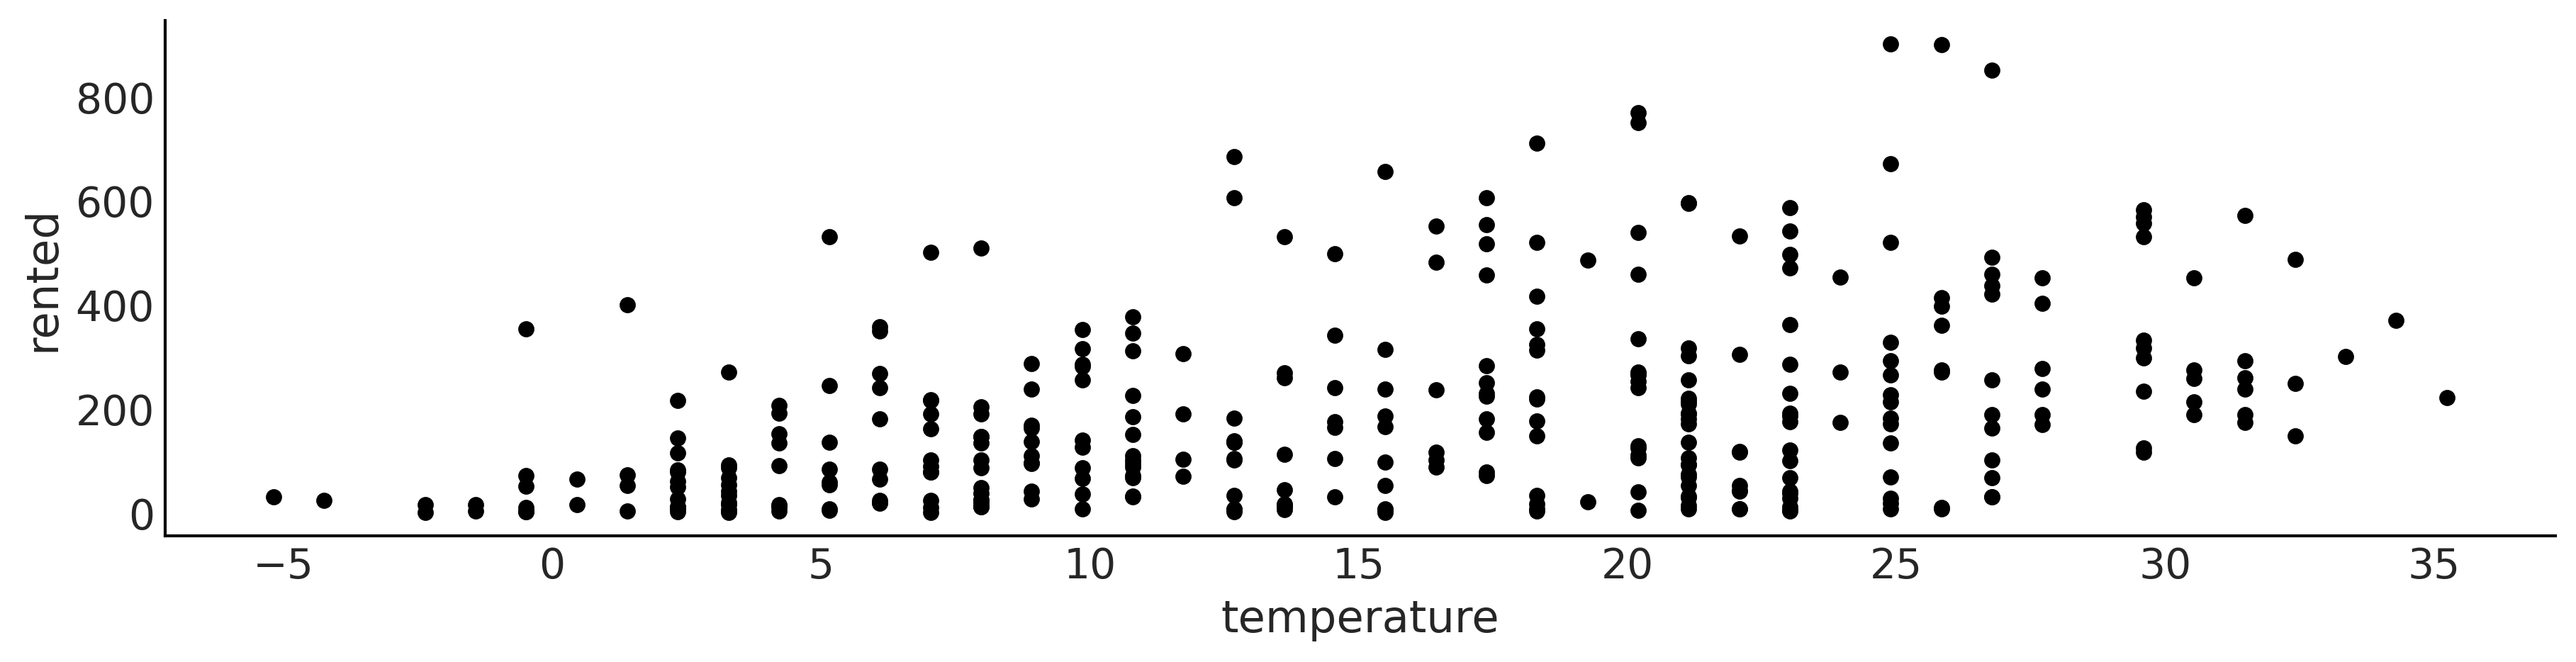

In [4]:
bikes = pd.read_csv("data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [5]:
with pm.Model() as model_lb:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)
    μ = pm.Deterministic("μ", α + β * bikes.temperature)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

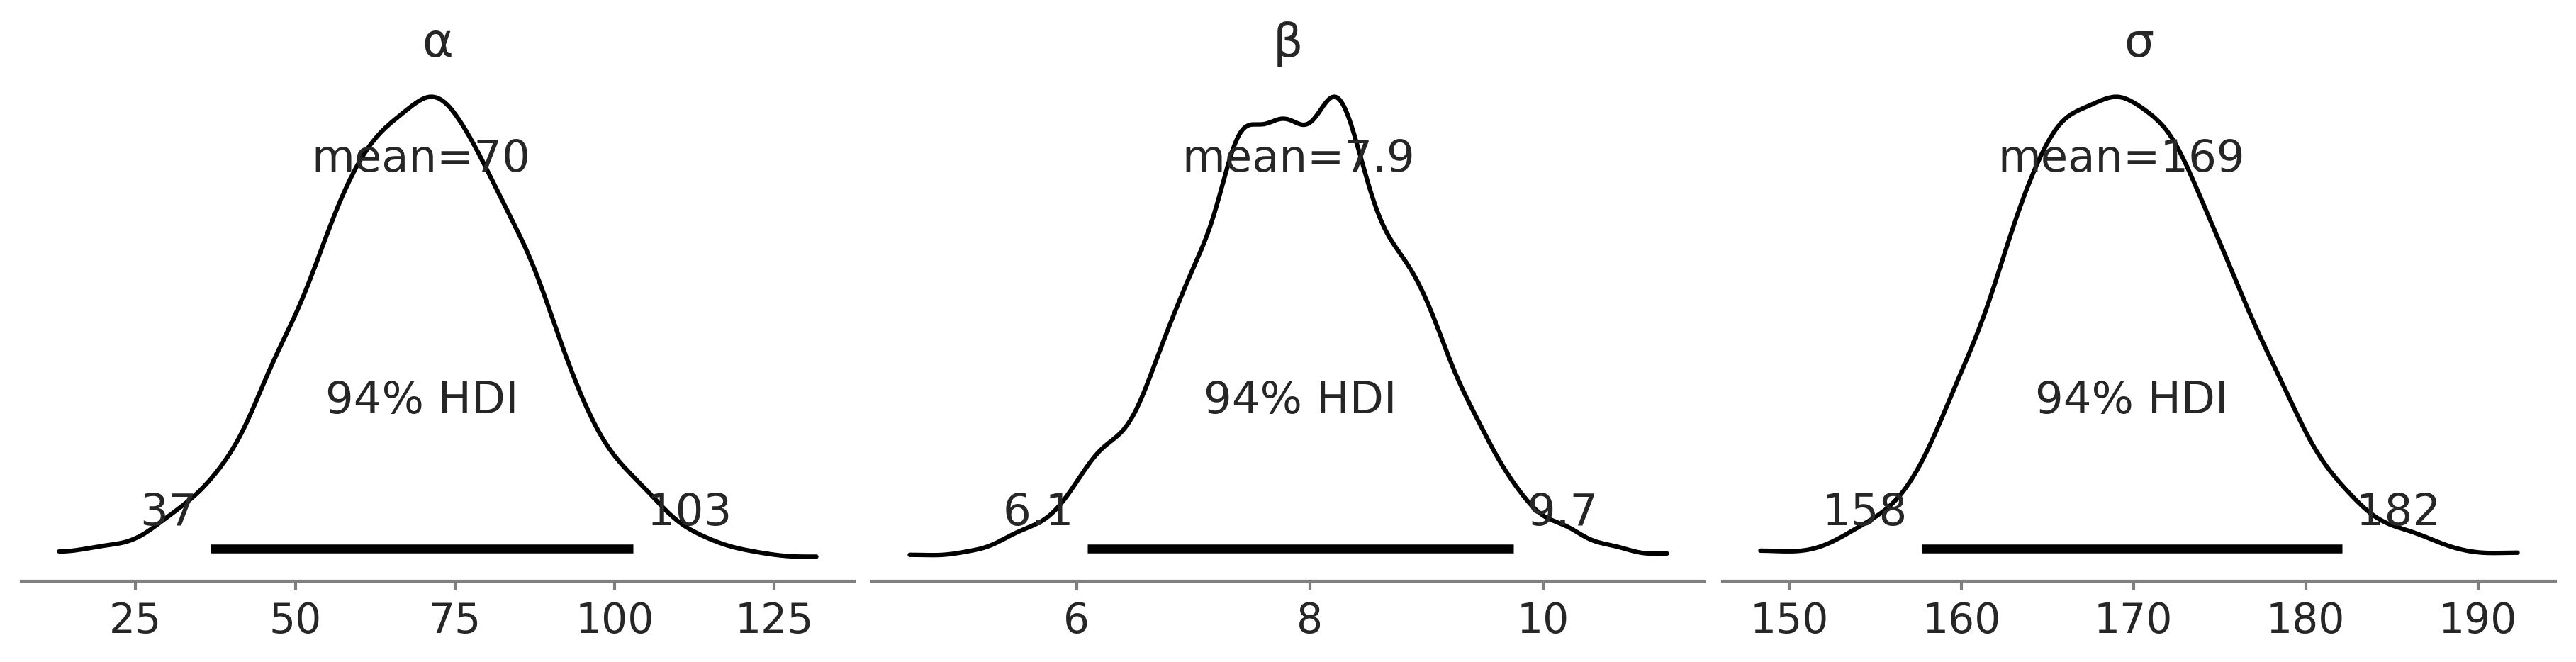

In [6]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

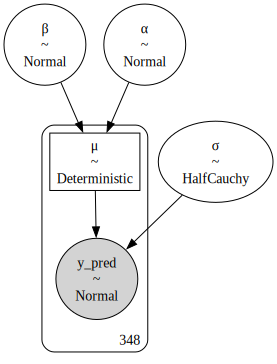

In [7]:
pm.model_to_graphviz(model_lb)

In [34]:
idata_lb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [8]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50),
    dims="plot_id"
)

In [9]:
posterior

<xarray.Dataset>
Dimensions:  (sample: 50, μ_dim_0: 348)
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 340 341 342 343 344 345 346 347
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 1 2 1 1 0 3 3 0 0 0 0 0 ... 3 3 2 3 1 3 0 1 3 3 3 3
  * draw     (sample) int64 798 955 540 923 206 621 ... 975 365 171 413 465 368
Data variables:
    α        (sample) float64 52.45 94.29 77.89 83.73 ... 74.25 66.82 60.9 70.98
    β        (sample) float64 8.791 7.061 7.14 8.695 ... 7.249 8.294 8.124 8.088
    σ        (sample) float64 165.9 168.4 170.6 162.2 ... 161.0 172.7 170.1
    μ        (μ_dim_0, sample) float64 81.28 117.4 101.3 ... 133.0 125.7 135.5
Attributes:
    created_at:                 2024-04-06T22:58:17.443757
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.1724600791931152
    tuning_steps:               1000

In [11]:
x_plot

<xarray.DataArray (plot_id: 50)>
array([-5.18      , -4.35510204, -3.53020408, -2.70530612, -1.88040816,
       -1.0555102 , -0.23061224,  0.59428571,  1.41918367,  2.24408163,
        3.06897959,  3.89387755,  4.71877551,  5.54367347,  6.36857143,
        7.19346939,  8.01836735,  8.84326531,  9.66816327, 10.49306122,
       11.31795918, 12.14285714, 12.9677551 , 13.79265306, 14.61755102,
       15.44244898, 16.26734694, 17.0922449 , 17.91714286, 18.74204082,
       19.56693878, 20.39183673, 21.21673469, 22.04163265, 22.86653061,
       23.69142857, 24.51632653, 25.34122449, 26.16612245, 26.99102041,
       27.81591837, 28.64081633, 29.46571429, 30.29061224, 31.1155102 ,
       31.94040816, 32.76530612, 33.59020408, 34.41510204, 35.24      ])
Dimensions without coordinates: plot_id

In [12]:
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

In [13]:
mean_line

<xarray.DataArray (plot_id: 50)>
array([ 27.59810881,  34.17102278,  40.74393675,  47.31685072,
        53.88976469,  60.46267866,  67.03559264,  73.60850661,
        80.18142058,  86.75433455,  93.32724852,  99.90016249,
       106.47307646, 113.04599043, 119.6189044 , 126.19181837,
       132.76473234, 139.33764631, 145.91056028, 152.48347426,
       159.05638823, 165.6293022 , 172.20221617, 178.77513014,
       185.34804411, 191.92095808, 198.49387205, 205.06678602,
       211.63969999, 218.21261396, 224.78552793, 231.3584419 ,
       237.93135588, 244.50426985, 251.07718382, 257.65009779,
       264.22301176, 270.79592573, 277.3688397 , 283.94175367,
       290.51466764, 297.08758161, 303.66049558, 310.23340955,
       316.80632352, 323.3792375 , 329.95215147, 336.52506544,
       343.09797941, 349.67089338])
Dimensions without coordinates: plot_id

In [14]:
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])

In [15]:
hdi_lines

<xarray.Dataset>
Dimensions:  (μ_dim_0: 348, hdi: 2)
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 340 341 342 343 344 345 346 347
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    μ        (μ_dim_0, hdi) float64 69.11 125.2 31.81 ... 125.2 109.8 153.7

In [20]:
lines.T

<xarray.DataArray (plot_id: 50, sample: 50)>
array([[  6.91304077,  57.71175339,  40.90456219, ...,  23.85733688,
         18.82397212,  29.08203187],
       [ 14.16461117,  63.53645108,  46.79429923, ...,  30.69865999,
         25.52522804,  35.75361703],
       [ 21.41618158,  69.36114877,  52.68403628, ...,  37.5399831 ,
         32.22648397,  42.42520219],
       ...,
       [347.73684985, 331.47254484, 317.72220337, ..., 345.39952304,
        333.78300058, 342.64653427],
       [354.98842026, 337.29724253, 323.61194042, ..., 352.24084615,
        340.48425651, 349.31811943],
       [362.23999067, 343.12194022, 329.50167747, ..., 359.08216926,
        347.18551243, 355.98970459]])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 1 2 1 1 0 3 3 0 0 0 0 0 ... 3 3 2 3 1 3 0 1 3 3 3 3
  * draw     (sample) int64 798 955 540 923 206 621 ... 975 365 171 413 465 368
Dimensions without coordinates: plot_id

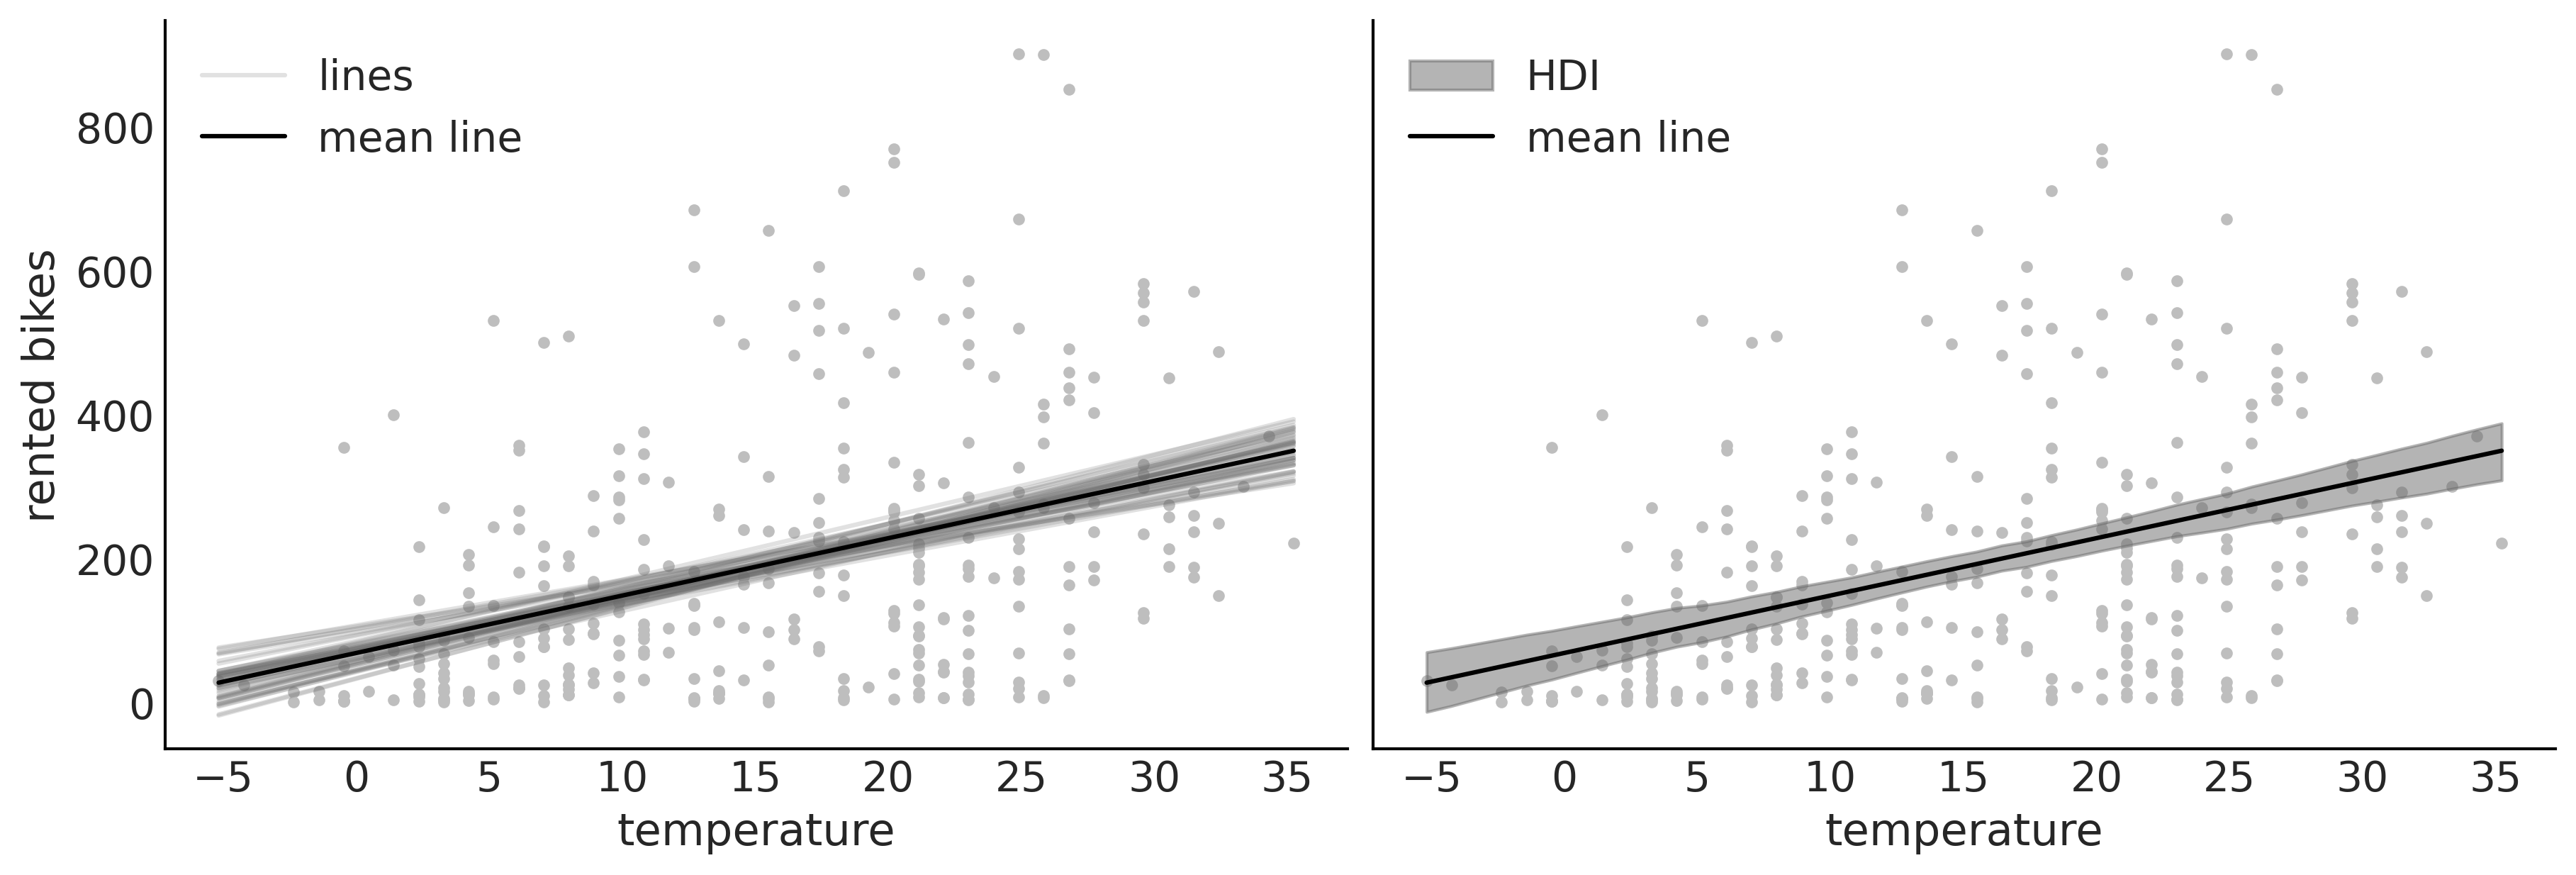

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:,0][idx],
    hdi_lines["μ"][:,1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
) 
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()

In [31]:
hdi_lines["μ"][:,0]

<xarray.DataArray 'μ' (μ_dim_0: 348)>
array([ 69.1058015 ,  31.81191673,  59.41359442,  50.46682235,
        59.41359442,  31.81191673,  14.18292743,  77.46354959,
        59.41359442,  77.46354959, -12.96361922,  31.81191673,
        41.21280224,  41.21280224,  50.46682235,  59.41359442,
        83.70971847, 101.49454075,  23.54651503,  14.18292743,
       127.49049887, 127.49049887, 230.86272616, 109.82430984,
        23.54651503, 109.82430984,  83.70971847, 101.49454075,
        69.1058015 , 168.28956757,  83.70971847, 109.82430984,
        69.1058015 ,  91.63399973, 135.57689465, 235.88556604,
       135.57689465, 152.73115166,  69.1058015 ,  69.1058015 ,
        59.41359442,  69.1058015 , 109.82430984, 210.77860829,
       160.96667876, 109.82430984, 183.01751039, 144.39630909,
       168.28956757, 152.73115166, 160.96667876, 152.73115166,
       109.82430984, 196.53601198, 217.70234903, 196.53601198,
       174.63984061, 248.40197597, 196.53601198, 196.53601198,
       183.01751039, 160.96667876, 174.63984061, 174.63984061,
       183.01751039, 188.40252435, 224.28473464, 260.09002316,
       278.85482958, 260.09002316, 289.98679271, 253.96156326,
       217.70234903, 217.70234903, 224.28473464, 230.86272616,
       217.70234903, 203.26990449, 230.86272616, 253.96156326,
...
       308.48790109, 284.64491864, 210.77860829, 273.35059692,
       248.40197597, 260.09002316, 241.2025581 , 224.28473464,
       230.86272616, 253.96156326, 241.2025581 , 284.64491864,
       273.35059692, 278.85482958, 253.96156326, 253.96156326,
       217.70234903, 217.70234903, 224.28473464, 224.28473464,
       230.86272616, 224.28473464, 260.09002316, 253.96156326,
       273.35059692, 273.35059692, 241.2025581 , 217.70234903,
       217.70234903, 188.40252435, 210.77860829, 152.73115166,
       196.53601198, 160.96667876, 210.77860829, 230.86272616,
       217.70234903, 217.70234903, 241.2025581 , 168.28956757,
       135.57689465, 152.73115166, 109.82430984, 196.53601198,
       119.52782609, 188.40252435, 160.96667876, 210.77860829,
       196.53601198, 196.53601198,  91.63399973,  91.63399973,
       101.49454075, 101.49454075, 152.73115166, 188.40252435,
       183.01751039,  91.63399973, 101.49454075, 119.52782609,
        83.70971847,  69.1058015 ,  59.41359442, 101.49454075,
       119.52782609, 109.82430984, 210.77860829, 152.73115166,
       127.49049887, 119.52782609,  91.63399973,  59.41359442,
       109.82430984, 127.49049887,  91.63399973,  77.46354959,
        83.70971847,  77.46354959,  69.1058015 , 109.82430984])
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 340 341 342 343 344 345 346 347
    hdi      <U6 'lower'